In [1]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
sim_1: SimulationStudy = SimulationStudy(p=10, mean_correlation=0.8, cor_variance=0.1, n=8000, geom=True)
simulation_1 = sim_1.create_dataset()


In [ ]:
cov, mean = SimulationStudy.get_covariance_matrix(sim_1)
cov = pd.DataFrame(cov)
cov

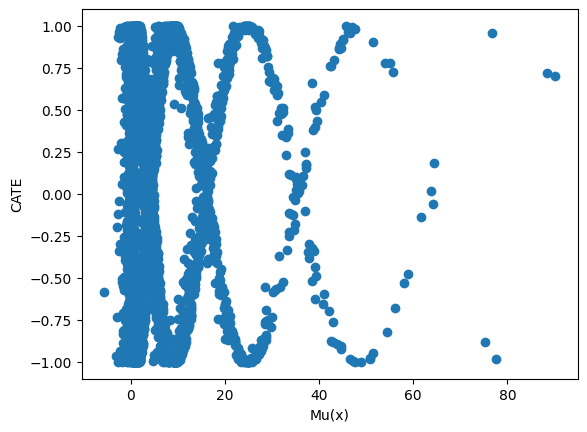

In [11]:
treated = simulation_1[simulation_1["T"] == 1]
plt.plot(treated["mu_x"], treated["CATE"], 'o')
plt.xlabel("Mu(x)")
plt.ylabel("CATE")
plt.show()

In [ ]:
x=treated[["mu_x"]]
y=treated[["CATE"]]


reg = LinearRegression().fit(x, y)
reg.score(x, y)

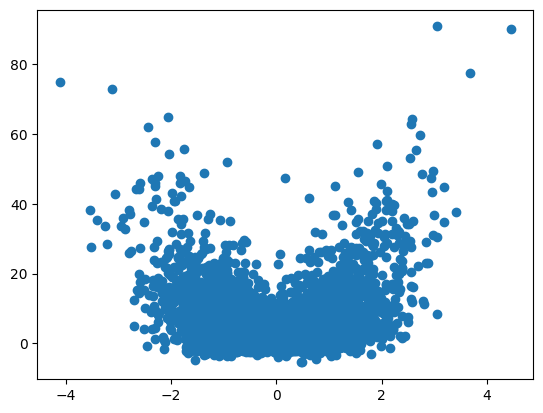

In [13]:
treated = simulation_1[simulation_1["T"] == 1]
x_var_treat = treated["X2"]
plt.plot(x_var_treat, treated["y"], 'o')

#untreated = simulation_1[simulation_1["T"] == 0]
#x_var_untreat = untreated["X1"]
#plt.plot(x_var_untreat, untreated["y"], 'o')

#fit polynomial regression
#poly_fit = np.polyfit(x_var_treat, treated["CATE"], np.sin)
#poly_fit_fn = np.poly1d(poly_fit)
#plt.plot(treated["X2"], poly_fit_fn(treated["X2"]))


In [ ]:
x_var=treated[["mu_x"]]
y_var=treated[["CATE"]]


reg = LinearRegression().fit(x, y)
reg.score(x, y)

In [ ]:
plt.plot(simulation_1["CATE"], simulation_2["CATE"], 'o')

In [ ]:
x = simulation_1[['CATE']]
y = simulation_2[['CATE']]

reg = LinearRegression().fit(x, y)
reg.score(x, y)